In [ ]:
# to reload local packages when debugging
%load_ext autoreload
%autoreload 2

%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

base_dir = 'results/runs_picked_for_processing' # stream_trained

def plot_metric(result_sets, metric, focused_form, title):
    plt.figure(figsize=(10, 4))  
    df = pd.DataFrame()

    for result_set_data_form, result_set_data in result_sets.items():
        means1 = np.array([ x[f'{metric}_mean'] for x in result_set_data ])
        # std1 = np.array([ x[f'{metric}_std'] for x in result_set_data ])
        timestamps1 = np.array([ x['last_ts'] for x in result_set_data ])

        # print(set_form_title)
        # print(f'Average Value: {np.mean(means1):.5g}, Highest Value: {np.max(means1):.5g}, Lowest Value: {np.min(means1):.5g}')
        df = pd.concat([df, pd.DataFrame({'mean_acc': np.mean(means1), 'low_acc': np.min(means1), 'high_acc': np.max(means1)}, index=[result_set_data_form])], axis=0)

        if result_set_data_form == focused_form:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        else:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        
        # plt.fill_between(timestamps1, means1 - std1, means1 + std1, alpha=0.3, label=f'{result_set_data_form} Std Dev')

    # plt.title(title) #(f'{title}: {metric}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{metric}')
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
    
    plt.xticks(fontsize=14,rotation=45) # Adjust X-axis tick label size
    plt.yticks(fontsize=14) # Adjust Y-axis tick label size
    plt.xlabel('Timestamp', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)

    # plt.tight_layout()  
    plt.savefig(f'figures/{title}_{metric}.png', bbox_inches='tight')
    # plt.show()
    
    df = df.reset_index().rename(columns={'index': 'data_form'})
    return df, plt


import os
# datasets = ['electricity', 'm4_daily_dataset', 'm4_daily_dataset_gluonts',  'london_smart_meters_without_missing', 'weather_dataset']
datasets = ['m4_daily_dataset']

def load_results(datasets):
    
    ar_res = {}
    cr_res = {}
    for dataset in datasets:
        res_dir = f'{base_dir}/{dataset}'
        ar_res[dataset] = {}
        cr_res[dataset] = {}
        for dir in os.listdir(res_dir):
            if '.' in dir:
                continue

            series_num = dir.split('[')[0].split('_')[-2]
            if series_num not in ar_res[dataset].keys():
                ar_res[dataset][series_num] = {}
                cr_res[dataset][series_num] = {}

            forms_string = dir.split(']')[0].split('[')[1]
            # map form strings to print friendly
            type_map = {"'o'": 'original', "'fd'": 'frac_diff', "'fod'": 'first_order_diff',
                        "'tao'": 'original_ta', "'tafd'": 'frac_diff_ta', "'tafod'": 'first_order_diff_ta',}
            forms_string = ' + '.join([type_map[abbr] for abbr in forms_string.replace(" ", "").split(",")])

            with open(f'{res_dir}/{dir}/adaptation_results.pkl', 'rb') as f:
                ar = pickle.load(f)
            with open(f'{res_dir}/{dir}/consolidation_results.pkl', 'rb') as f:
                cr = pickle.load(f)

            # ar_res[dataset][series_num].append((forms_string, ar))
            # cr_res[dataset][series_num].append((forms_string, cr))
            ar_res[dataset][series_num][forms_string] = ar
            cr_res[dataset][series_num][forms_string] = cr
    return ar_res, cr_res


def plot_res_build_resdf(ar_res, cr_res, metric='accuracy'):
    results = pd.DataFrame()
    focused_form = 'original + frac_diff'

    for key, value in ar_res.items(): # item = dataset_name, series dict
        dataset = key
        res_dir = f'{base_dir}/{dataset}'
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            title = f'adap_{dataset}_{series_num}' #f'Comparison of Adaptation {metric} for {dataset}_{series_num}'
            df, plt = plot_metric(value, metric, focused_form, title)
            df['dataset'] = dataset
            df['value_type'] = 'adaptation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/ada_comp_{metric}_{series_num}.png')
    for key, value in cr_res.items(): # item = dataset_name, series dict
        dataset = key
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            title = f'cons_{dataset}_{series_num}' #f'Comparison of Consolidation {metric} for {dataset}_{series_num}'
            df, plt = plot_metric(value, metric, focused_form, title)
            df['dataset'] = dataset
            df['value_type'] = 'consolidation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/cons_comp_{metric}_{series_num}.png')

    return results

import itertools
def append_stab(res_pack, results, value_type, metric='accuracy'):
    metric_key = f'{metric}_mean'
    form_keys = ['original', 'frac_diff', 'first_order_diff', 'original_ta', 'frac_diff_ta', 'first_order_diff_ta'] # individual forms
    form_keys = [' + '.join(combo) 
        for r in range(1, len(form_keys) + 1) 
        for combo in itertools.combinations(form_keys, r)
    ] # all combinations of the forms
    
    for dataset in res_pack.keys():
        for series_num in res_pack[dataset].keys():
            for form in form_keys:
                if form in res_pack[dataset][series_num].keys():
                    metric_vals = [ res[metric_key] for res in res_pack[dataset][series_num][form] ]
                    var = np.var(metric_vals)
                    mean = np.mean(metric_vals)
                    coeff_var = (np.std(metric_vals) / np.mean(metric_vals)) * 100
                    # append the values to the passed results df
                    idx = results.loc[results['dataset'] == dataset].loc[ results['value_type'] == value_type].loc[results['series_num'] == series_num].loc[results['data_form'] == form].index
                    results.loc[idx, 'stab_var'] = var
                    results.loc[idx, 'stab_mean'] = mean
                    results.loc[idx, 'stab_coeff_var'] = coeff_var
    return results

# convert index of missing timestamps to datetime using starting point
def impute_ts(res_pack, dataset, starting_point, dataset_length):
    date_lookup = pd.date_range(start=starting_point, periods=dataset_length, freq='D').to_list()
    for series in res_pack[dataset].keys():
        for data_form in res_pack[dataset][series].keys():
            for i, res in enumerate(res_pack[dataset][series][data_form]):
                if type(res['last_ts']) == int or type(res['last_ts']) == np.int64:
                    res_pack[dataset][series][data_form][i]['last_ts'] = date_lookup[res['last_ts']]
    return res_pack



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/c/Users/resha/Documents/Github/balancing_framework


,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,frac_diff,0.715917,0.610200,0.854200,sp500_run1,adaptation,1,0.002445,0.715917,6.907383
1,first_order_diff,0.604066,0.496800,0.816800,sp500_run1,adaptation,1,0.005258,0.604066,12.004334
2,original,0.741918,0.635200,0.882100,sp500_run1,adaptation,1,0.002312,0.741918,6.481119
3,original + frac_diff + first_order_diff,0.852205,0.776200,0.936200,sp500_run2,adaptation,1,0.001230,0.852205,4.114546
4,original + frac_diff,0.827573,0.709500,0.941600,sp500_run2,adaptation,1,0.002264,0.827573,5.749676
5,original + first_order_diff,0.735276,0.618500,0.872600,sp500_run2,adaptation,1,0.002459,0.735276,6.744326
6,original,0.741918,0.635200,0.882100,sp500_run2,adaptation,1,0.002312,0.741918,6.481119
7,original + frac_diff + first_order_diff,0.735276,0.618500,0.872600,sp500_run3,adaptation,1,0.002459,0.735276,6.744326
8,original + frac_diff,0.827573,0.709500,0.941600,sp500_run3,adaptation,1,0.002264,0.827573,5.749676
9,original + first_order_diff,0.735276,0.618500,0.872600,sp500_run3,adaptation,1,0.002459,0.735276,6.744326


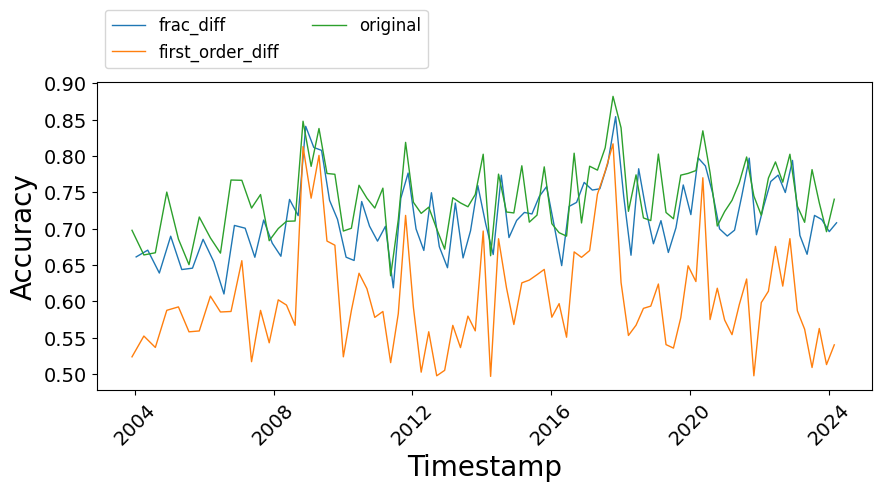

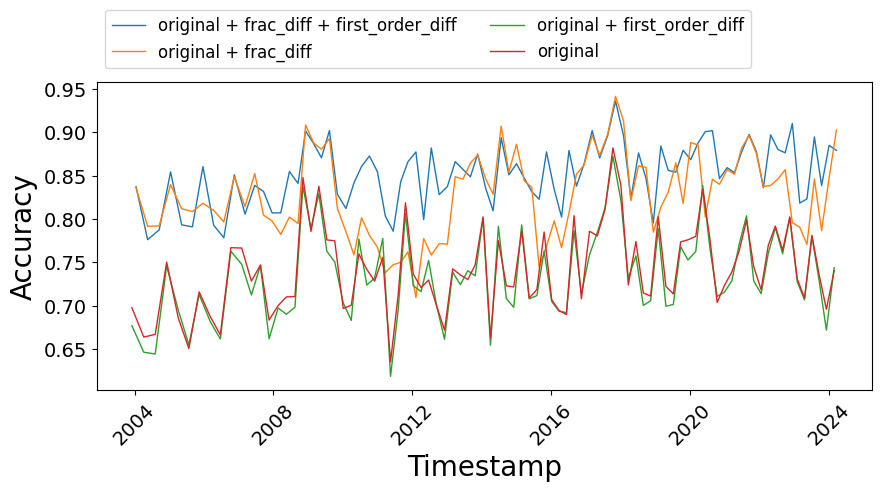

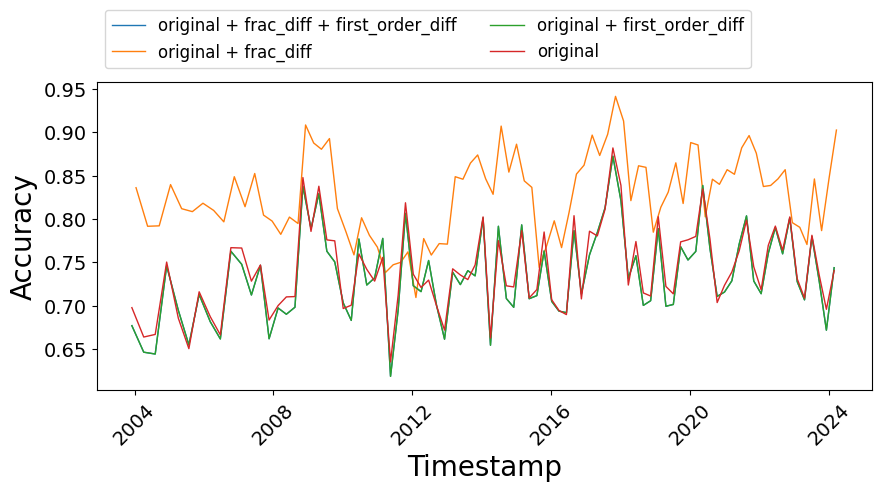

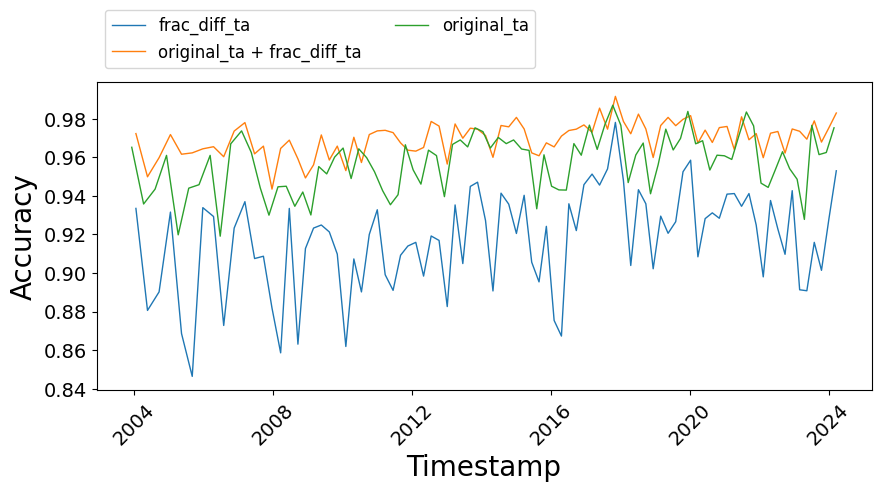

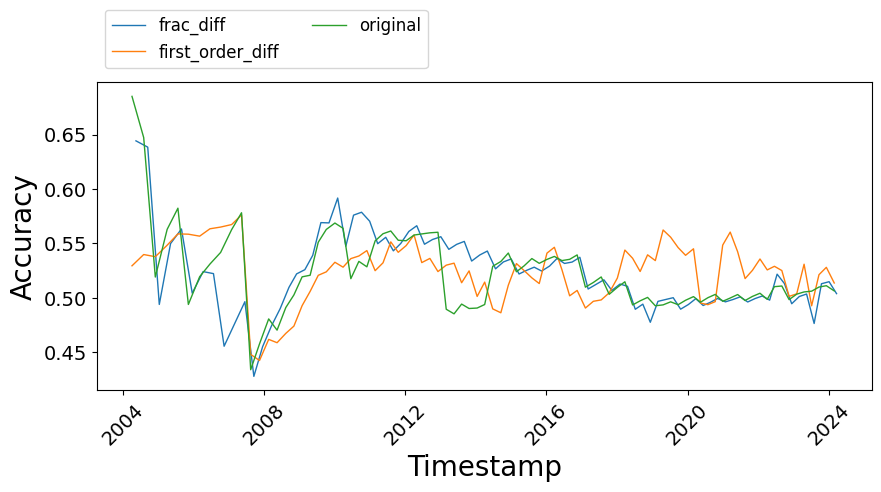

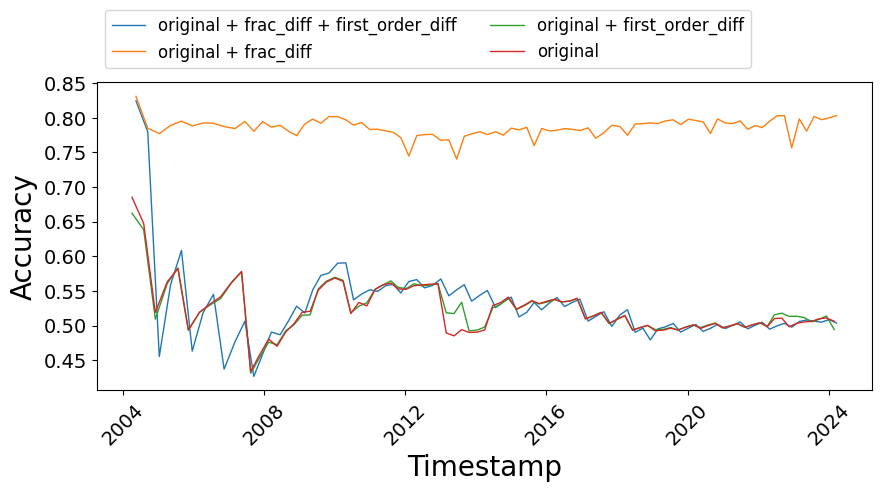

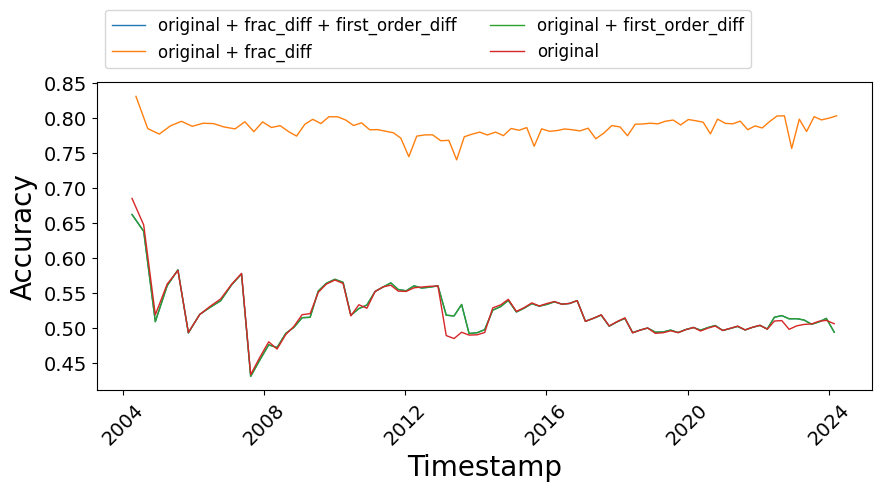

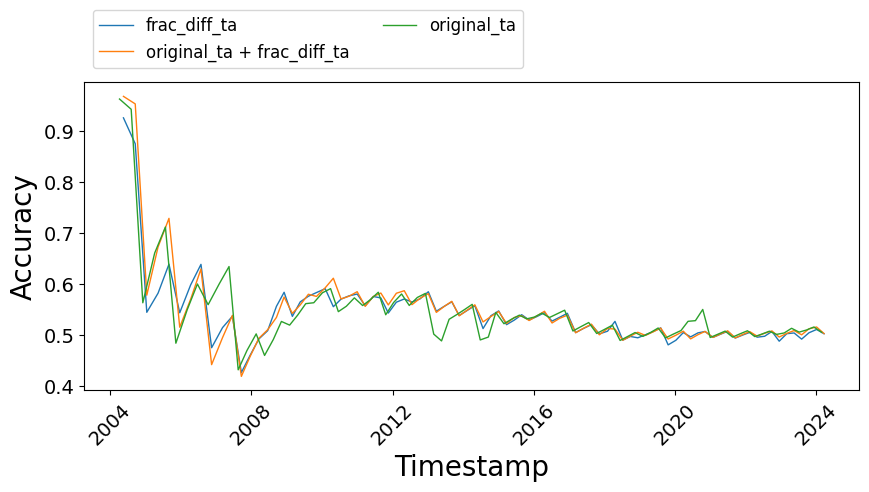

In [ ]:
datasets = ['m4_daily_dataset', 'sp500_run1', 'sp500_run2', 'sp500_run3', 'sp500_run4'] # 'm4_daily_dataset', 

ar_res, cr_res = load_results(datasets)

# ar_res = impute_ts(ar_res, 'm4_daily_dataset', '1997-07-22', 8531)
# cr_res = impute_ts(cr_res, 'm4_daily_dataset', '1997-07-22', 8531)

results = plot_res_build_resdf(ar_res, cr_res)

results = append_stab(ar_res, results, 'adaptation')
results = append_stab(cr_res, results, 'consolidation')
results